In [3]:
import numpy as np
import h5py
from nbodykit.lab import *
import nbodykit 
import matplotlib.pyplot as plt

In [18]:
def power_spectrum(filename, L_side=0):
    print(filename)
    f = h5py.File(filename, 'r')
    divergence = f['divergence'][...]
    f.close()

    cosmo = cosmology.Planck15    
    f = cosmo.scale_independent_growth_rate(0.0)
    
    delta = -divergence/(100 * cosmo.h)
        
    delta_mesh = nbodykit.source.mesh.array.ArrayMesh(delta, L_side) 
    r = FFTPower(delta_mesh, mode='1d', dk=0.002, kmin=0.005)
    Pk = r.power

    return {'k': Pk['k'], 'Pk':(Pk['power'].real- Pk.attrs['shotnoise'])}

In [44]:
path = "/Users/forero/data/AbacusCosmos/AbacusCosmos_720box_planck_00_00_FoF_halos_z0.100/fields/"
pk = {}
sigmas = [1.0, 3.0, 5.0, 7.0, 10.0]
for sigma in sigmas:
    filename = "velocity_AbacusCosmos_720box_planck_00_0_FoF_vmax_300.0_sigma_{:.1f}_nside_360.hdf5".format(sigma)
    pk["300_{:.1f}".format(sigma)] = power_spectrum(path+filename, L_side=720.0)

/Users/forero/data/AbacusCosmos/AbacusCosmos_720box_planck_00_00_FoF_halos_z0.100/fields/velocity_AbacusCosmos_720box_planck_00_0_FoF_vmax_300.0_sigma_1.0_nside_360.hdf5
/Users/forero/data/AbacusCosmos/AbacusCosmos_720box_planck_00_00_FoF_halos_z0.100/fields/velocity_AbacusCosmos_720box_planck_00_0_FoF_vmax_300.0_sigma_3.0_nside_360.hdf5
/Users/forero/data/AbacusCosmos/AbacusCosmos_720box_planck_00_00_FoF_halos_z0.100/fields/velocity_AbacusCosmos_720box_planck_00_0_FoF_vmax_300.0_sigma_5.0_nside_360.hdf5
/Users/forero/data/AbacusCosmos/AbacusCosmos_720box_planck_00_00_FoF_halos_z0.100/fields/velocity_AbacusCosmos_720box_planck_00_0_FoF_vmax_300.0_sigma_7.0_nside_360.hdf5
/Users/forero/data/AbacusCosmos/AbacusCosmos_720box_planck_00_00_FoF_halos_z0.100/fields/velocity_AbacusCosmos_720box_planck_00_0_FoF_vmax_300.0_sigma_10.0_nside_360.hdf5


In [89]:
path = "/Users/forero/data/AbacusCosmos/AbacusCosmos_720box_planck_00_00_FoF_halos_z0.100/fields/"
vels = [125.0, 180.0, 300.0]
for vel in vels:
    filename = "velocity_AbacusCosmos_720box_planck_00_0_FoF_vmax_{:.1f}_sigma_3.0_nside_360.hdf5".format(vel)
    pk["{}_3.0".format(int(vel))] = power_spectrum(path+filename, L_side=720.0)

/Users/forero/data/AbacusCosmos/AbacusCosmos_720box_planck_00_00_FoF_halos_z0.100/fields/velocity_AbacusCosmos_720box_planck_00_0_FoF_vmax_125.0_sigma_3.0_nside_360.hdf5
/Users/forero/data/AbacusCosmos/AbacusCosmos_720box_planck_00_00_FoF_halos_z0.100/fields/velocity_AbacusCosmos_720box_planck_00_0_FoF_vmax_180.0_sigma_3.0_nside_360.hdf5
/Users/forero/data/AbacusCosmos/AbacusCosmos_720box_planck_00_00_FoF_halos_z0.100/fields/velocity_AbacusCosmos_720box_planck_00_0_FoF_vmax_300.0_sigma_3.0_nside_360.hdf5


Text(0.5, 1.0, 'Biased Tracers + Gaussian Smoothing')

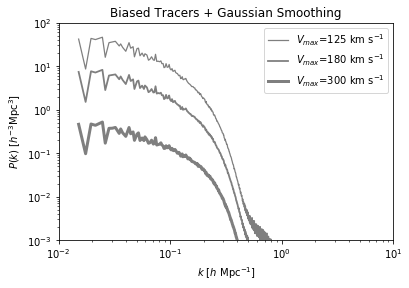

In [100]:
vels = [125.0, 180.0, 300.0]
for vel in vels:
    plt.loglog(pk["{}_3.0".format(int(vel))]['k'], 
               pk["{}_3.0".format(int(vel))]['Pk'], 
               label="$V_{{max}}$={:.0f} km s$^{{-1}}$".format(vel),
               linewidth=vel/100.0, color='black', alpha=0.5)

# format the axes
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$ [$h^{-3}\mathrm{Mpc}^3$]")
plt.legend()
plt.xlim(1E-2, 10.0)
plt.ylim(1E-3, 1E2)
plt.title("Biased Tracers + Gaussian Smoothing")

Text(0.5, 1.0, 'Biased Tracers + Gaussian Smoothing')

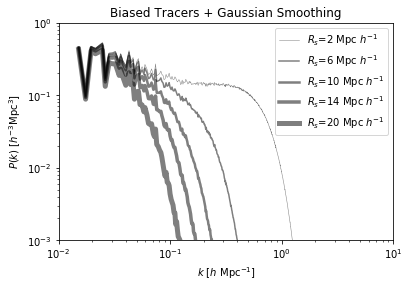

In [83]:
sigmas = [1.0, 3.0, 5.0, 7.0, 10.0]
for sigma in sigmas:
    plt.loglog(pk['300_{:.1f}'.format(sigma)]['k'], 
               pk['300_{:.1f}'.format(sigma)]['Pk'], 
               label="$R_s$={:.0f} Mpc $h^{{-1}}$".format(2*sigma),
               linewidth=sigma/2.0, color='black', alpha=0.5)

# format the axes
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$ [$h^{-3}\mathrm{Mpc}^3$]")
plt.legend()
plt.xlim(1E-2, 10.0)
plt.ylim(1E-3,1E0)
plt.title("Biased Tracers + Gaussian Smoothing")

In [63]:
path = "/Users/forero/github/WatershedAbacus/nb/"
sigmas = [1.0, 3.0, 5.0, 7.0, 10.0]
for sigma in sigmas:
    filename = "mock_divergence_mesh_360_box_720_slim_{}.h5".format(int(2.0*sigma))
    pk["mock_720_{:.1f}".format(sigma)] = power_spectrum(path+filename, L_side=720.0)

/Users/forero/github/WatershedAbacus/nb/mock_divergence_mesh_360_box_720_slim_2.h5
/Users/forero/github/WatershedAbacus/nb/mock_divergence_mesh_360_box_720_slim_6.h5
/Users/forero/github/WatershedAbacus/nb/mock_divergence_mesh_360_box_720_slim_10.h5
/Users/forero/github/WatershedAbacus/nb/mock_divergence_mesh_360_box_720_slim_14.h5
/Users/forero/github/WatershedAbacus/nb/mock_divergence_mesh_360_box_720_slim_20.h5


Text(0.5, 1.0, 'Gaussian Field + Truncated Power Spectrum')

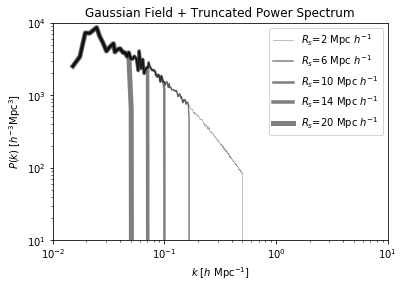

In [84]:
sigmas = [1.0, 3.0, 5.0, 7.0, 10.0]
for sigma in sigmas:
    plt.loglog(pk['mock_720_{:.1f}'.format(sigma)]['k'], 
               pk['mock_720_{:.1f}'.format(sigma)]['Pk'], 
               label="$R_s$={:.0f} Mpc $h^{{-1}}$".format(2*sigma), 
              linewidth=sigma/2.0, color='black', alpha=0.5)


# format the axes
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$ [$h^{-3}\mathrm{Mpc}^3$]")
plt.legend()
plt.xlim(1E-2, 10.0)
plt.ylim(1E1,1E4)
plt.title("Gaussian Field + Truncated Power Spectrum")